In [113]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 
print("hi")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hi


In [114]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [115]:
global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1" ,                 # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)
#GRU 1st, GRU 2nd, and CNN LSTM for 2nd 

#add hyperp. tuning 

Num GPUs Available:  0


In [116]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False:       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot !
#False, True, False:        X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:        X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:         X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True:         X.shape = (4846500, 14), Y.shape = (4846500, 1) !!!!
#True, True, True:          X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True #stack series
cond2 = False #multiclass
cond3 = True #propogate output
#true f t is the !
#F F F is the !!!
fract = 1
#inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)
steping = 1
inputs, outputs = load_anomaly(input_path, output_path, cond1, cond2, cond3, fract, steping)

In [117]:
inputs.shape

(4846500, 14)

In [118]:
outputs.shape

(4846500, 1)

In [119]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (time steps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * time steps  (time steps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features    (features) object 'Class_Fault' 'Class_Run'

In [120]:
data = xr.concat([inputs, outputs], dim="features")
data.shape

(4846500, 16)

In [121]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)


In [122]:
inputs.shape

(4846491, 10, 14)

In [123]:
outputs.shape

(4846491, 2)

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [125]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [126]:

xtrain.shape

(3392543, 10, 14)

In [127]:
ytrain.shape

(3392543, 2)

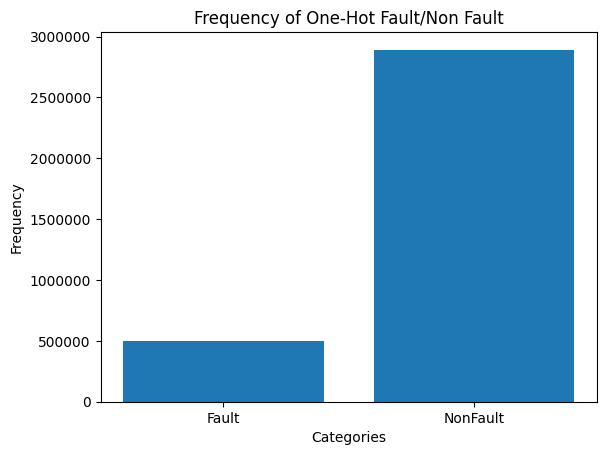

<xarray.DataArray (samples: 3392543, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 1652843 2542055 1602538 ... 1273258 293429 2987159
  * features  (features) object 'Class_Fault' 'Class_Run'

In [128]:
ytrain

frequency = np.sum(ytrain, axis=0)

# Categories
categories = ['Fault', 'NonFault']

# Plot
plt.bar(categories, frequency)
plt.title('Frequency of One-Hot Fault/Non Fault')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()
ytrain

In [129]:
ytrain.shape

(3392543, 2)

In [130]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "input_shape": xtrain.shape[1:],
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "return_sequences": True,
    },
    "LSTM": {
        "num_layers": mai.Int(0, 3),
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "return_sequences": True,
    },
        
    "GRU": {  # Adding GRU layer
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

    },
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
    "Dense": {
        "num_layers": mai.Int(0, 3),
        "units": 25,
        "activation": "relu",
    },
    "Dense_output": {
        "units": ytrain.shape[-1],
        "activation": "sigmoid",
    },
}

model_settings = {
    "models": ["LSTM", "GRU"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": {"learning_rate": mai.Float(1e-5, 0.001)},
        "compile_params": {
            "loss": "binary_crossentropy",
            "metrics": ["accuracy"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([32, 64, 128]),
            "epochs": 5,
            "validation_split": 0.15,
        },
    },
    "GRU": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": {"learning_rate": mai.Float(1e-5, 0.001)},
        "compile_params": {
            "loss": "binary_crossentropy",
            "metrics": ["accuracy"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([32, 64, 128]),
            "epochs": 5,
            "validation_split": 0.15,
        },
    },
    
}





tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)


In [ ]:
import time
from sklearn.model_selection import TimeSeriesSplit
start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=20,
    cv=TimeSeriesSplit(n_splits=2),
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyper-parameter tuning neural networks with bayesian search

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |0                 |LSTM_num_layers
2                 |2                 |GRU_num_layers
2                 |2                 |Dense_num_layers
0.00063816        |0.00063816        |Adam_learning_rate

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
35339/35339 [==============================] - 83s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5


In [ ]:
xtrain

In [ ]:
ytrain.shape

In [ ]:
xtrain.shape

In [ ]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 500}},
    },
  #  y_scaler=y_scaler,
)

In [ ]:
postprocessor.metrics()

In [ ]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

In [ ]:
idx = postprocessor._get_idx()
idx

In [ ]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [ ]:
postprocessor.get_model()

In [ ]:
 yhat_test

In [ ]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [ ]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

In [ ]:
#ax = plt.gca()

In [ ]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [ ]:
xtrain.shape

In [ ]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

In [ ]:
yhat_train.shape

In [ ]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [ ]:
ytrain_single = np.argmax(ytrain, axis=1)

In [ ]:
yhat_train_single.shape

In [ ]:
ytrain_single.shape

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


In [ ]:
train_disp.plot()

In [ ]:
ytest = np.round(ytest).astype(int)
ytest.shape

In [ ]:
yhat_test.shape

In [ ]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [ ]:
ytest_single = np.argmax(ytest, axis=1)

In [ ]:
yhat_test_single.shape

In [ ]:
ytest_single.shape

In [ ]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



In [ ]:
test_disp.plot()

In [ ]:
##use pyMAISE one

In [ ]:
xtrain.shape